# Import Libraries


In [1]:
import pandas as pd
import numpy as np
import os
import nltk
import tensorflow as tf
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
import warnings
from collections import Counter
from utils.textnormalization import text_normalization
from utils.machinelearning import machine_learning_model, fit_model
from utils.deeplearning import model_compile, model_fit, lstm_, gru_, bidirectional_lstm
from utils.plot_model_changes import plot_changes
from utils.sentimentinformation import sentiment_percentage, sentiment_counts
from utils.wordcloud import wordcloud
from utils.most_frequent_word_plot import bar_plot
from utils.deeplearning_preprcosesing import  deeplearning_preprcosesing_
from utils.word_vector import word_vector_
from utils.confusion_matrix import confusion_matrix_, confusion_matrix_display
from utils.generate_poitive_negative import generate_poitive_negative
from utils.performance_metrics import accuracy_score, precision_score, sensitivity_score, specificity_score, f1_score, error_rate, performance_metrics_data_frame
from utils.model_inference import machine_learning_inference, deep_learning_inference
from utils.transformers_ import sentiment_analysis_transformers
from utils.word_2_vec import word_2_vec_
pd.options.display.max_rows = 100
pd.options.display.max_columns =None 
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

# Download Some Packages

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

# Ignore Warnings

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings(action='ignore')

# Read Data

In [4]:
Corpus = pd.read_csv('Balanced-Review.txt', sep="\t")
Corpus['rating'].value_counts()
sentiment = []
for i in Corpus['rating']:
    if i == 1 or i == 2:
        sentiment.append('Negative')
    else:
        sentiment.append('Positive')
Corpus['Sentiment'] = sentiment
Corpus.rename(columns={'review': 'Review'}, inplace=True)
Corpus = Corpus[['Review', 'Sentiment']]
Corpus['Review'] = Corpus['Review'].astype(str)
Corpus = Corpus.sample(frac=1, random_state=55, ignore_index=True)
Corpus.index = Corpus.index + 1 
Corpus.tail(10)

Review Sentiment
105689        ممتاز. نظافة المكان. عدم وجود واي فاي مجاني  Positive
105690  “لا تعتمد علي فنادق الاصيل لعدم احترامهم الحجو...  Negative
105691       “لابأس”. أقرب من الحرم. ازعاج الآخرين بالغرف  Negative
105692  جيد. الارضية باركيهالموقع جيد. المكيفات من نوع...  Positive
105693  “تجربة سيئة جدا”. قرب الفندق من محطة مترو صلاح...  Negative
105694  “زيارتي للفندق هذه لن تتكرر ولو بالمجان”. بدون...  Negative
105695  “سئ”. . زي الزفت الغرف سيئة جدا السراير غير مر...  Negative
105696  “جميل ورائع”. كل شي تمام النظافه والخدمه والمو...  Positive
105697  “تجربة سيئة”. سيء للغاية. موظفين الاستقبالنظاف...  Negative
105698   “الهدوء الجمال”. الهدوء وقربه من التسوق. لا يوجد  Negative

# Validation Data

In [5]:
reviews = ["لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.",
       "الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.",
        "كانت الأسرة في الغرفة مريحة جدًا.",
        "الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.",
        "كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.",
        "الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.",
        "الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.",
        "الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.",
        "استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.",
        "المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إلى تجديدات عاجلة.",]

# Word To Vector Data

In [6]:
Data = pd.read_csv('Arabic-Data.txt', header=None, sep = "\t", on_bad_lines='skip', encoding='utf-8', encoding_errors='ignore',  skiprows=[5219414,5219439])

# Sentiment Information

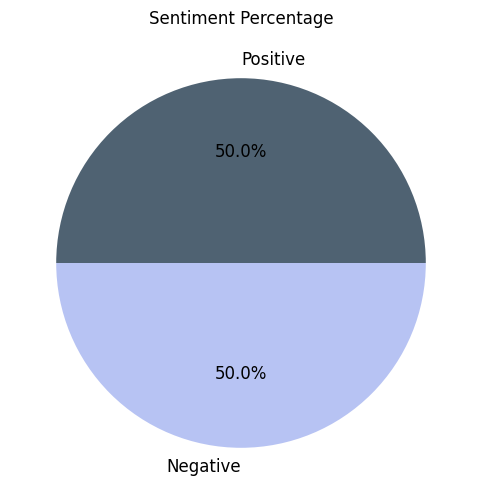

In [7]:
sentiment_percentage(Corpus, 'Sentiment', (6, 6))

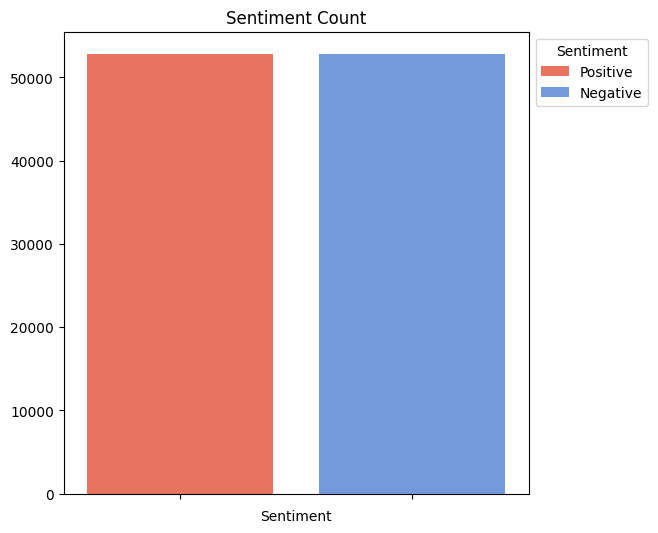

In [8]:
sentiment_counts(Corpus, 'Sentiment', (6, 6))

# Number Of Sentences

In [9]:
Corpus['NumberOfSentences'] = Corpus['Review'].apply(lambda n:len(sent_tokenize(n)))
Corpus.drop(Corpus[Corpus["NumberOfSentences"] == 0].index, inplace = True)
Corpus['NumberOfSentences'].sum()

316380

# Average Number Of Sentences

In [10]:
AverageNumberOfSentence = int(np.round(Corpus["NumberOfSentences"].mean()))
AverageNumberOfSentence

3

# Maximum Number Of Sentences

In [11]:
MaximumNumberOfSentence = Corpus["NumberOfSentences"].max()
MaximumNumberOfSentence

93

# Minimum Number Of Sentences

In [12]:
MinimumNumberOfSentence = Corpus["NumberOfSentences"].min()
MinimumNumberOfSentence

1

# Number Of Words Before Review Normalization

In [13]:
Corpus["Number of Words 1"] = Corpus["Review"].apply(lambda n:len(word_tokenize(n)))
Corpus["Number of Words 1"].sum()

2886975

# Average Number Of Words Before Review Normalization

In [14]:
AverageNaumberOfWords1 = int(np.round((Corpus["Number of Words 1"].mean())))
AverageNaumberOfWords1

27

# Maximum Number Of Word Before Review Normalization

In [15]:
MaximumNaumberOfWords1 = Corpus["Number of Words 1"].max()
MaximumNaumberOfWords1

623

# Minimum Number Of Words Before Review Normalization

In [16]:
MimimumNaumberOfWords1 = Corpus["Number of Words 1"].min()
MimimumNaumberOfWords1

3

# Number Of Charachters Before Review Normalization

In [17]:
Corpus["Number of Charachters 1"] = Corpus["Review"].apply(lambda n:sum(chr.isalpha() for chr in n))
Corpus["Number of Charachters 1"].sum()

11484118

# Average Number Of Charachters Before Review Normalization

In [18]:
AverageNumberOfCharachters1 = int(np.round(Corpus["Number of Charachters 1"].mean()))
AverageNumberOfCharachters1

109

# Maximum Number Of Charachters Before Review Normalization

In [19]:
MaximumNumberOfCharachters1 = Corpus['Number of Charachters 1'].max() 
MaximumNumberOfCharachters1

2705

# Minimum Number Of Charachters Before Review Normalization

In [20]:
MinimumNumberOfCharachters1 = Corpus['Number of Charachters 1'].min() 
MinimumNumberOfCharachters1

0

In [21]:
Corpus[Corpus['Number of Charachters 1'] == 0]

Review Sentiment  NumberOfSentences  \
3245                          “👍🏻”. 👍🏻. 👍🏻  Positive                  3   
7880                             “*”. *. *  Negative                  3   
30736   “....”. ............ .............  Negative                  2   
34960                              “3 . .   Positive                  2   
39587                                “. .   Negative                  2   
49228               “,,,,,,,,,,”. . ,,,,,,  Negative                  3   
50038                            “-”. -. -  Positive                  3   
53698                               “9. .   Positive                  2   
61507                     “...”. .... ....  Positive                  2   
79917                          “4 😑”. . 4😑  Negative                  3   
81037                            “!”. !. !  Negative                  3   
96418                           “❤️”. 👍. 👆  Positive                  3   
98424                                “. .   Negative                  2   
99097                   “.....”. .... ....  Positive                  2   
105685                            “١”. . 2  Positive                  3   

        Number of Words 1  Number of Charachters 1  
3245                    7                        0  
7880                    7                        0  
30736                   6                        0  
34960                   4                        0  
39587                   3                        0  
49228                  20                        0  
50038                   7                        0  
53698                   4                        0  
61507                   6                        0  
79917                   7                        0  
81037                   7                        0  
96418                   7                        0  
98424                   3                        0  
99097                   6                        0  
105685                  6                        0

# Most Frequent Words Before Review Normalization

In [22]:
MostFrequentWord1 = Counter((Corpus['Review']).str.split().explode()).most_common(15)
MostFrequentWordDF1 = pd.DataFrame(MostFrequentWord1, columns=('Word', 'Count'), index=range(1, 16))
MostFrequentWordDF1

Word  Count
1          من  50502
2          في  48501
3      الفندق  33246
4          لا  27415
5           .  26495
6         جدا  25571
7           و  21856
8         غير  18140
9          كل  17111
10        على  15785
11  الاستقبال  15195
12      الغرف  14316
13         شي  13558
14         لم  13302
15       يوجد  11825

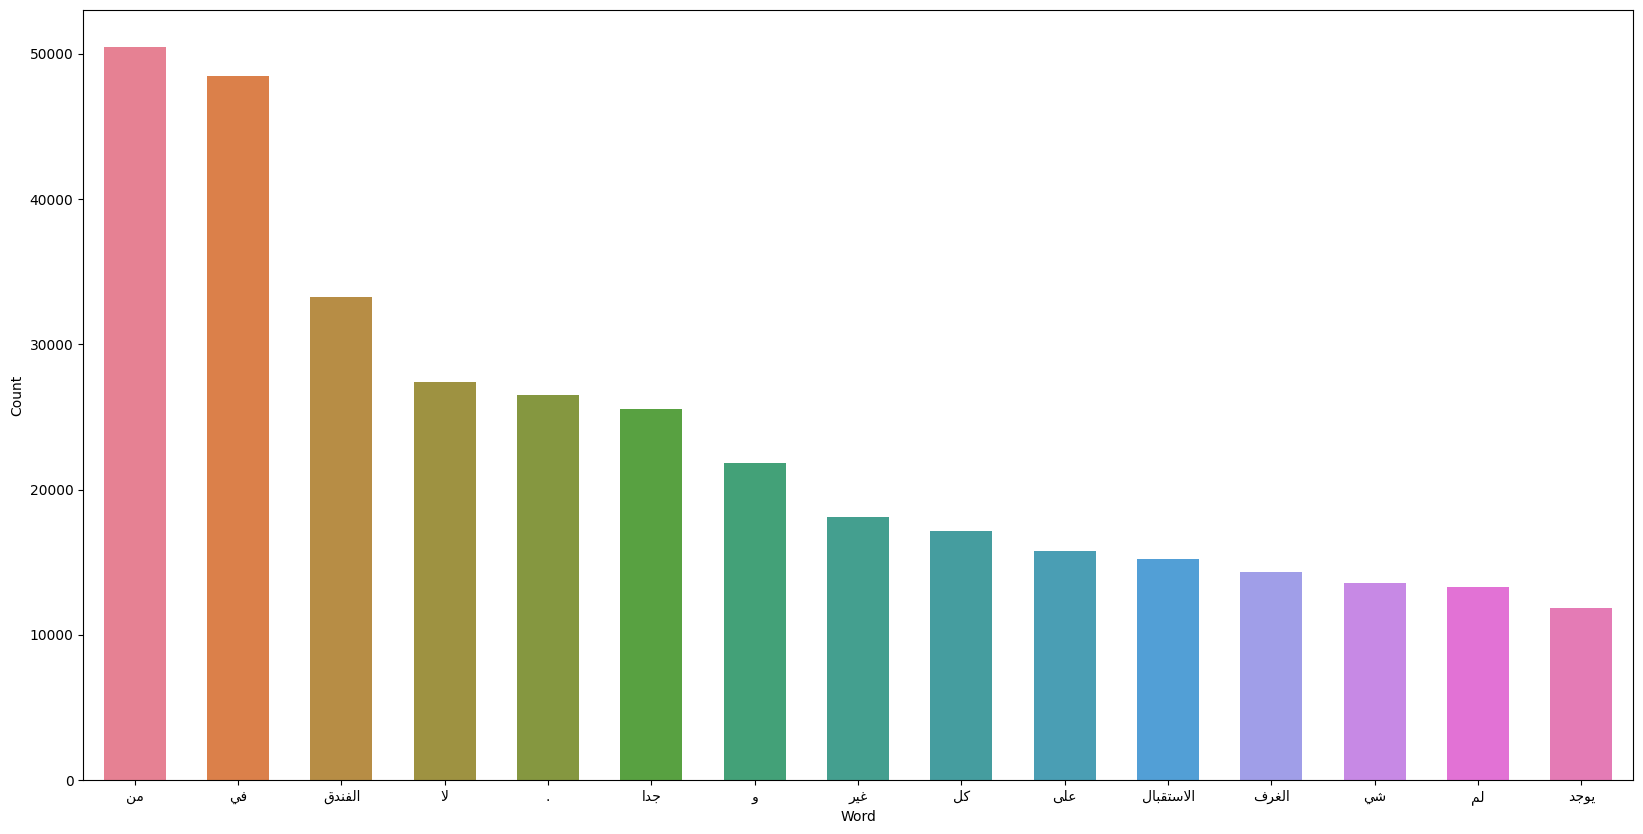

In [23]:
bar_plot(data=MostFrequentWordDF1, text = 'Word', x = 'Word', y='Count')

# Review Normalization

In [24]:
Corpus['Normalized_Review'] = Corpus['Review'].map(text_normalization)
Corpus.dropna(axis=1, inplace=True)
Corpus.to_csv('Normalized Corpus.csv')
Corpus.tail(5)

Review Sentiment  \
105694  “زيارتي للفندق هذه لن تتكرر ولو بالمجان”. بدون...  Negative   
105695  “سئ”. . زي الزفت الغرف سيئة جدا السراير غير مر...  Negative   
105696  “جميل ورائع”. كل شي تمام النظافه والخدمه والمو...  Positive   
105697  “تجربة سيئة”. سيء للغاية. موظفين الاستقبالنظاف...  Negative   
105698   “الهدوء الجمال”. الهدوء وقربه من التسوق. لا يوجد  Negative   

        NumberOfSentences  Number of Words 1  Number of Charachters 1  \
105694                  3                 55                      232   
105695                  3                 20                       71   
105696                  3                 15                       50   
105697                  3                 23                      117   
105698                  3                 12                       37   

                                        Normalized_Review  
105694  “زيارتي للفندق تتكرر ولو بالمجان” مبالغه يعجبن...  
105695  “سئ” زي الزفت الغرف سيئه السراير مريحه الفرش م...  
105696  “جميل ورائع” شي تمام النظافه والخدمه والموقع و...  
105697  “تجربه سيئه” سيء موظفين الاستقبالنظافه الجناحض...  
105698           “الهدوء الجمال” الهدوء وقربه التسوق يوجد

# Number Of Unique Words

In [25]:
UniqueWords = set()
for word in Corpus['Normalized_Review'].str.split():
    UniqueWords.update(word)
len(UniqueWords)

133569

# WordCloud

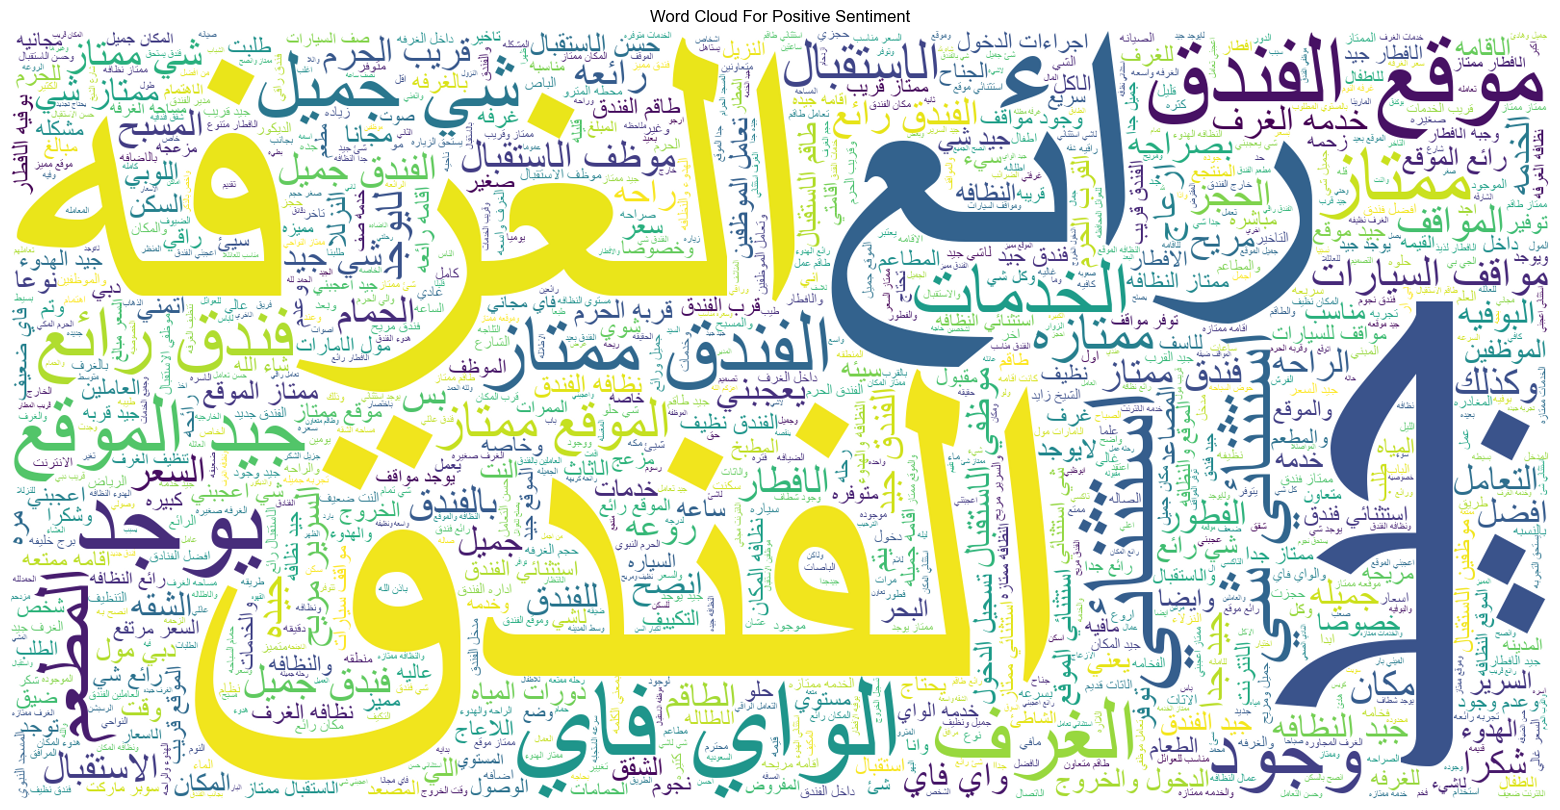

In [26]:
wordcloud(data=Corpus, target='Positive', width=1600, hieght=800, review='Normalized_Review', max_words= 1000)

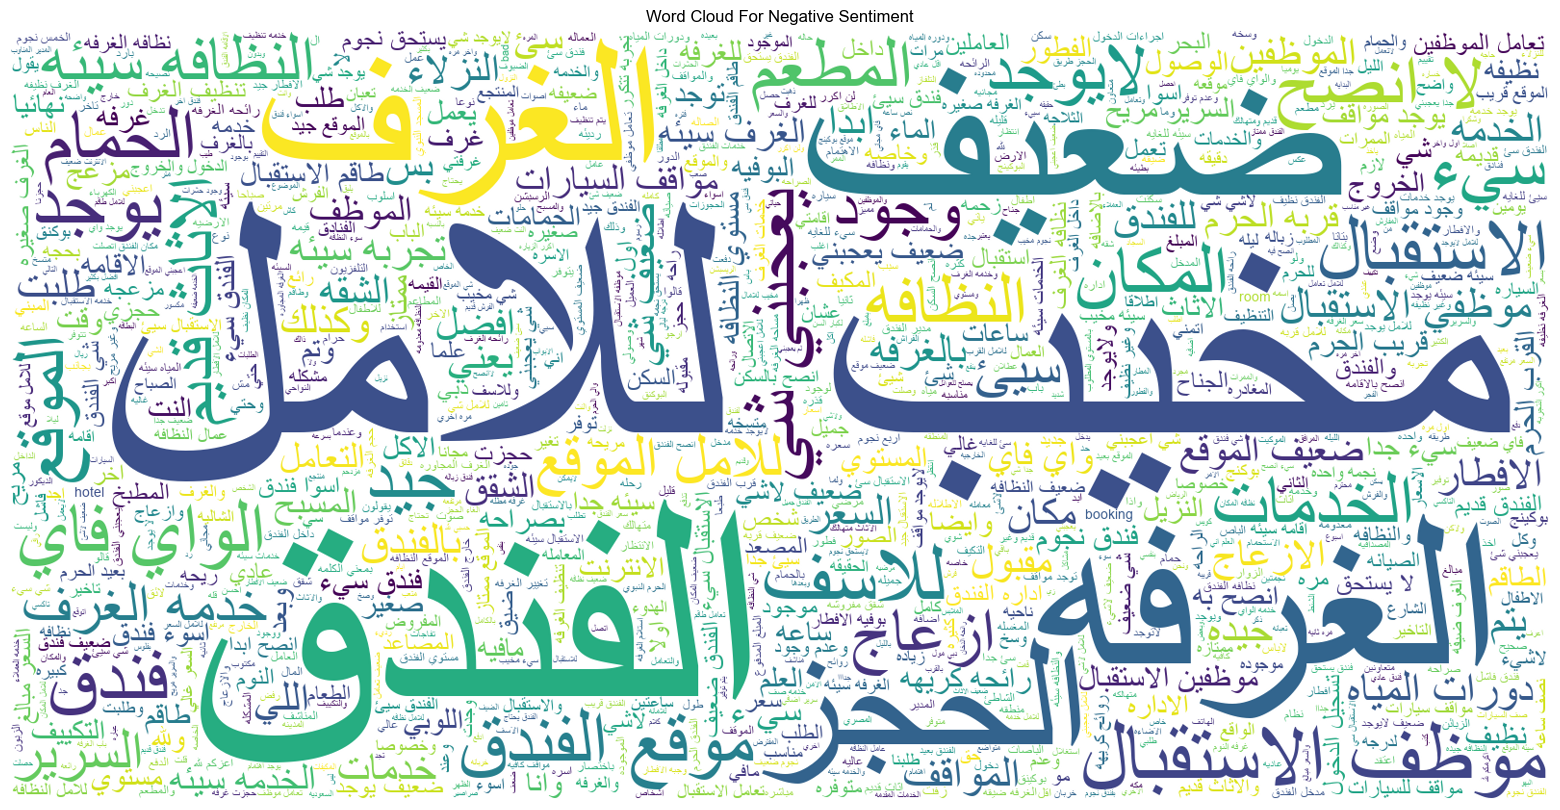

In [27]:
wordcloud(data=Corpus, target='Negative', width=1600, hieght=800, review='Normalized_Review', max_words= 1000)

# Number Of Words After Review Normalization

In [28]:
Corpus["Number of Words 2"] = Corpus["Normalized_Review"].apply(lambda n:len(word_tokenize(n)))
Corpus.drop(Corpus[Corpus["Number of Words 2"] == 0].index, inplace = True)
Corpus["Number of Words 2"].sum()

1951764

# Average Number Of Words After Review Normalization

In [29]:
AverageNaumberOfWords2 = int(np.round((Corpus["Number of Words 2"].mean())))
AverageNaumberOfWords2

18

# Maximum Number Of Word After Review Normalization

In [30]:
MaximumNaumberOfWords2 = Corpus["Number of Words 2"].max()
MaximumNaumberOfWords2

393

# Minimum Number Of Words After Review Normalization

In [31]:
MimimumNaumberOfWords2 = Corpus["Number of Words 2"].min()
MimimumNaumberOfWords2

1

# Number Of Charachters After Review Normalization

In [32]:
Corpus["Number of Charachters 2"] = Corpus["Normalized_Review"].str.len()
Corpus["Number of Charachters 2"].sum()

11515459

# Average Number Of Charachters After Review Normalization

In [33]:
AverageNumberOfCharachters2 = int(np.round(Corpus["Number of Charachters 2"].mean()))
AverageNumberOfCharachters2

109

# Maximum Number Of Charachters After Review Normalization

In [34]:
MaximumNumberOfCharachters2 = Corpus['Number of Charachters 2'].max() 
MaximumNumberOfCharachters2

2427

# Minimum Number Of Charachters After Review Normalization

In [35]:
MinimumNumberOfCharachters2 = Corpus['Number of Charachters 2'].min() 
MinimumNumberOfCharachters2

1

# Most Frequent Words After Review Normalization

In [36]:
MostFrequentWord2 = Counter((Corpus['Normalized_Review']).str.split().explode()).most_common(15)
MostFrequentWordDF2 = pd.DataFrame(MostFrequentWord2, columns=('Word', 'Count'), index=range(1, 16))
MostFrequentWordDF2

Word  Count
1      الفندق  36534
2   الاستقبال  18056
3      الغرفه  17219
4          شي  16704
5         جيد  16413
6       الغرف  15454
7        ضعيف  14238
8      الموقع  13310
9        يوجد  12345
10      ممتاز  12318
11    النظافه  11777
12       مخيب   9607
13      للامل   9542
14       سيئه   8981
15       فندق   8208

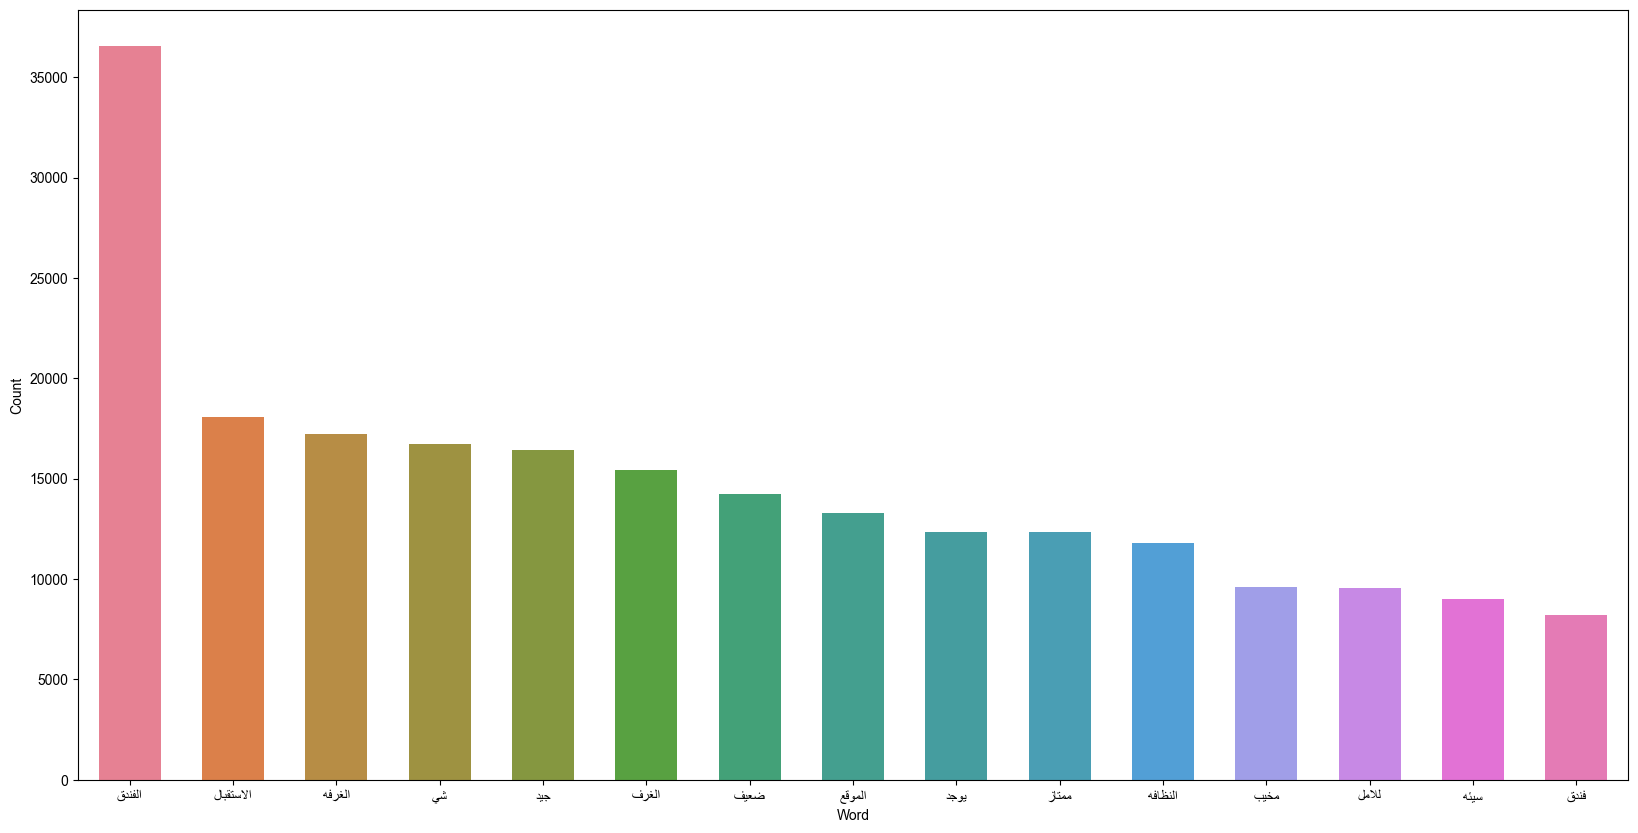

In [37]:
bar_plot(data=MostFrequentWordDF2, text = 'Word', x = 'Word', y='Count')

# Most Frequent Words Of Each Sentiment

**1-Positive**

In [38]:
Positive = Corpus[Corpus['Sentiment'] == 'Positive']

In [39]:
PositiveMostFrequentWord = Counter((Positive['Normalized_Review']).str.split().explode()).most_common(10)
PositiveMostFrequentWordDF = pd.DataFrame(PositiveMostFrequentWord, columns=('Word', 'Count'), index=range(1, 11))
PositiveMostFrequentWordDF

Word  Count
1      الفندق  16593
2         جيد  13365
3       ممتاز  10974
4          شي   8384
5   الاستقبال   7889
6        رائع   7398
7    استثنائي   7310
8      الموقع   6427
9      الغرفه   6266
10      الغرف   5891

**2-Negative**

In [40]:
Negative = Corpus[Corpus['Sentiment'] == 'Negative']

In [41]:
NegativeMostFrequentWord = Counter((Negative['Normalized_Review']).str.split().explode()).most_common(10)
NegativeMostFrequentWordDF = pd.DataFrame(NegativeMostFrequentWord, columns=('Word', 'Count'), index=range(1, 11))
NegativeMostFrequentWordDF

Word  Count
1      الفندق  19941
2        ضعيف  13192
3      الغرفه  10953
4   الاستقبال  10167
5        مخيب   9604
6       الغرف   9563
7       للامل   9540
8        سيئه   8325
9          شي   8320
10       يوجد   7911

# Part Of Speech Tagging (POS)

In [42]:
word_ = list(UniqueWords)
pos = nltk.pos_tag(word_)
word = []
tag = []

In [43]:
for i in pos:
    word.append(i[0])
    tag.append(i[1])

In [44]:
pos = pd.DataFrame(zip(word, tag), columns=['Word', 'Tag'])
pos.head()

Word  Tag
0            Bea  NNP
1           نشطف  NNP
2        دائمعدم  NNP
3   الجنسيهادوات  NNP
4  والمخداتحشرات  NNP

In [45]:
pos['Tag'].value_counts()

Tag
NNP     129871
NN        1396
JJ         521
VBD        422
VBZ        351
VBP        183
VBG        175
NNS        160
RB         118
VB         100
MD          60
IN          51
FW          47
JJS         18
PRP         17
DT          16
VBN         13
PRP$         9
JJR          8
CD           8
WRB          6
CC           5
RBR          4
WP           3
EX           2
TO           2
POS          1
WDT          1
NNPS         1
Name: count, dtype: int64

# Bigrams

In [46]:
Corpus['Bigrams'] = Corpus['Normalized_Review'].apply(lambda x: list(nltk.bigrams(x.split( ))))
Corpus

Review Sentiment  \
1       استثنائي. . ادوات النظافه في دورة المياه، الصا...  Positive   
2       مخيب للأمل. . الاستقبال عند وصولي في البداية ق...  Negative   
3       “رحلة عمرة مميزه”. اطلالته على الحرم المكى ورؤ...  Positive   
4       “موقع وقيمة رائعة”. الموقع أكثر من رائع , نظاف...  Positive   
5       “سلطان”. . انه يوجد في الموقع خدمة مجالسة الاط...  Positive   
...                                                   ...       ...   
105694  “زيارتي للفندق هذه لن تتكرر ولو بالمجان”. بدون...  Negative   
105695  “سئ”. . زي الزفت الغرف سيئة جدا السراير غير مر...  Negative   
105696  “جميل ورائع”. كل شي تمام النظافه والخدمه والمو...  Positive   
105697  “تجربة سيئة”. سيء للغاية. موظفين الاستقبالنظاف...  Negative   
105698   “الهدوء الجمال”. الهدوء وقربه من التسوق. لا يوجد  Negative   

        NumberOfSentences  Number of Words 1  Number of Charachters 1  \
1                       3                 13                       57   
2                       3                 27                      104   
3                       3                 22                       84   
4                       3                 26                      101   
5                       3                 16                       53   
...                   ...                ...                      ...   
105694                  3                 55                      232   
105695                  3                 20                       71   
105696                  3                 15                       50   
105697                  3                 23                      117   
105698                  3                 12                       37   

                                        Normalized_Review  Number of Words 2  \
1       استثنائي ادوات النظافه المياه الصابون الشامبو ...                  7   
2       مخيب للامل الاستقبال وصولي البدايه غرف متوفره ...                 13   
3       “رحله عمره مميزه” اطلالته الحرم المكي ورؤيه ال...                 17   
4       “موقع وقيمه رائعه” الموقع رائع نظافه وهدوء الغ...                 18   
5       “سلطان” يوجد الموقع خدمه مجالسه الاطفال تتوفر ...                 10   
...                                                   ...                ...   
105694  “زيارتي للفندق تتكرر ولو بالمجان” مبالغه يعجبن...                 42   
105695  “سئ” زي الزفت الغرف سيئه السراير مريحه الفرش م...                 15   
105696  “جميل ورائع” شي تمام النظافه والخدمه والموقع و...                 11   
105697  “تجربه سيئه” سيء موظفين الاستقبالنظافه الجناحض...                 20   
105698           “الهدوء الجمال” الهدوء وقربه التسوق يوجد                  8   

        Number of Charachters 2  \
1                            53   
2                            83   
3                            97   
4                           103   
5                            52   
...                         ...   
105694                      243   
105695                       76   
105696                       56   
105697                      130   
105698                       40   

                                                  Bigrams  
1       [(استثنائي, ادوات), (ادوات, النظافه), (النظافه...  
2       [(مخيب, للامل), (للامل, الاستقبال), (الاستقبال...  
3       [(“رحله, عمره), (عمره, مميزه”), (مميزه”, اطلال...  
4       [(“موقع, وقيمه), (وقيمه, رائعه”), (رائعه”, الم...  
5       [(“سلطان”, يوجد), (يوجد, الموقع), (الموقع, خدم...  
...                                                   ...  
105694  [(“زيارتي, للفندق), (للفندق, تتكرر), (تتكرر, و...  
105695  [(“سئ”, زي), (زي, الزفت), (الزفت, الغرف), (الغ...  
105696  [(“جميل, ورائع”), (ورائع”, شي), (شي, تمام), (ت...  
105697  [(“تجربه, سيئه”), (سيئه”, سيء), (سيء, موظفين),...  
105698  [(“الهدوء, الجمال”), (الجمال”, الهدوء), (الهدو...  

[105698 rows x 9 columns]

# Split The Dataset Into X And y

In [47]:
X, y = Corpus['Normalized_Review'], Corpus['Sentiment']

# Encoding Dependent Variables (Y) Into Integer

In [48]:
y = y.map({'Negative': 0, 'Positive': 1})

# Split The Dataset Into Training And Testing

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=22, stratify=y)

# Vectorizer

In [50]:
Vectorizer = TfidfVectorizer()
X_train_vec = Vectorizer.fit_transform(X_train)
X_test_vec = Vectorizer.transform(X_test)

# Word Mapping

In [51]:
Word_mapping = Vectorizer.vocabulary_
Word_mapping_ =pd.DataFrame((list(Word_mapping.items())), columns=['Word', 'Mapping'])
Word_mapping_.head()

Word  Mapping
0     فندق    58916
1      جيد    43624
2     مريح    74768
3     انصح    27850
4  الاقامه    10177

# Machine Learning

**1-Naive Bayes**

In [52]:
Algorithm = MultinomialNB(alpha= 1)
model_1 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_1, X_train=X_train_vec, y_train=y_train)

MultinomialNB(alpha=1)

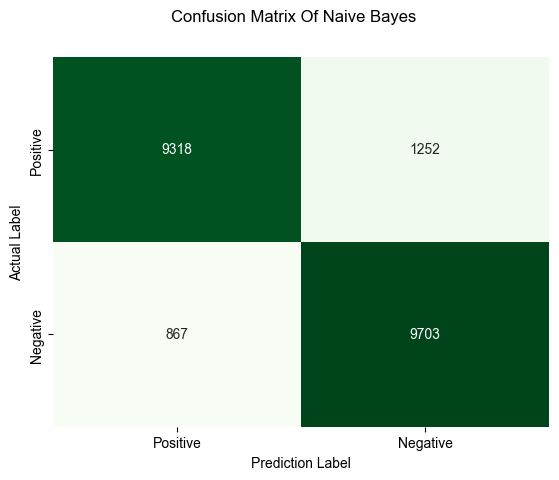

In [53]:
y_predNB = model_1.predict(X_test_vec)
ConfusionMatrixNB = confusion_matrix_(y_test = y_test, y_pred=y_predNB)
confusion_matrix_display(confusion_matrix = ConfusionMatrixNB, name = 'Naive Bayes')

In [54]:
False_PositiveNB, True_PositiveNB, False_NegativeNB, True_NegativeNB = generate_poitive_negative(confusion_matrix=ConfusionMatrixNB)

In [55]:
AccuracyNB = accuracy_score(True_Positive = True_PositiveNB, True_Negative = True_NegativeNB, False_Positive =False_PositiveNB, False_Negative = False_NegativeNB)
PrecisionNB= precision_score(True_Positive = True_PositiveNB, False_Positive= False_PositiveNB)

SensitivityNB = sensitivity_score(True_Positive = True_PositiveNB,  False_Negative = False_NegativeNB)
SpecificityNB = specificity_score(True_Negative = True_NegativeNB, False_Positive = False_PositiveNB)

F1ScoreNB = f1_score(True_Positive = True_PositiveNB, False_Negative = False_NegativeNB, False_Positive = False_PositiveNB)
ErrorNB = error_rate(True_Positive = True_PositiveNB, True_Negative = True_NegativeNB, False_Positive =False_PositiveNB, False_Negative = False_NegativeNB)

In [56]:
performance_metrics_data_frame(Accuracy = AccuracyNB, Precision = PrecisionNB, Sensitivity = SensitivityNB, Specificity = SpecificityNB, F1Score = F1ScoreNB, Error = ErrorNB)

Values
Accuracy     0.899763
Precision    0.881552
Sensitivity  0.914875
Specificity  0.885714
F1Score      0.897904
Error        0.100237

**2-Logistic Regression**

In [57]:
Algorithm = LogisticRegression()
model_2 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_2, X_train=X_train_vec, y_train=y_train)

LogisticRegression()

In [58]:
y_predLR = model_2.predict(X_test_vec)

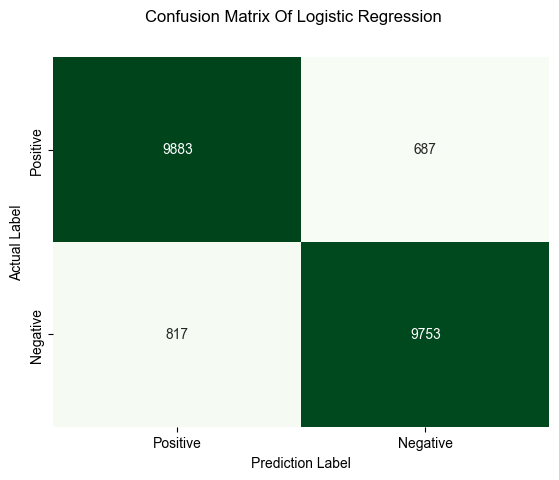

In [59]:
ConfusionMatrixLR = confusion_matrix_(y_test= y_test, y_pred=y_predLR)
confusion_matrix_display(confusion_matrix = ConfusionMatrixLR, name = 'Logistic Regression')

In [60]:
False_PositiveLR, True_PositiveLR, False_NegativeLR, True_NegativeLR = generate_poitive_negative(confusion_matrix=ConfusionMatrixLR)

In [61]:
AccuracyLR = accuracy_score(True_Positive = True_PositiveLR, True_Negative = True_NegativeLR, False_Positive =False_PositiveLR, False_Negative = False_NegativeLR)
PrecisionLR= precision_score(True_Positive = True_PositiveLR, False_Positive= False_PositiveLR)

SensitivityLR = sensitivity_score(True_Positive = True_PositiveLR,  False_Negative = False_NegativeLR)
SpecificityLR = specificity_score(True_Negative = True_NegativeLR, False_Positive = False_PositiveLR)

F1ScoreLR = f1_score(True_Positive = True_PositiveLR, False_Negative = False_NegativeLR, False_Positive = False_PositiveLR)
ErrorLR = error_rate(True_Positive = True_PositiveLR, True_Negative = True_NegativeLR, False_Positive =False_PositiveLR, False_Negative = False_NegativeLR)

In [62]:
performance_metrics_data_frame(Accuracy = AccuracyLR, Precision = PrecisionLR, Sensitivity = SensitivityLR, Specificity = SpecificityLR, F1Score = F1ScoreLR, Error = ErrorLR)

Values
Accuracy     0.928855
Precision    0.935005
Sensitivity  0.923645
Specificity  0.934195
F1Score      0.929290
Error        0.071145

**3-Decision Tree**

In [63]:
Algorithm = DecisionTreeClassifier(criterion='gini')
model_3 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_3, X_train=X_train_vec, y_train=y_train)

DecisionTreeClassifier()

In [64]:
y_predDT = model_3.predict(X_test_vec)

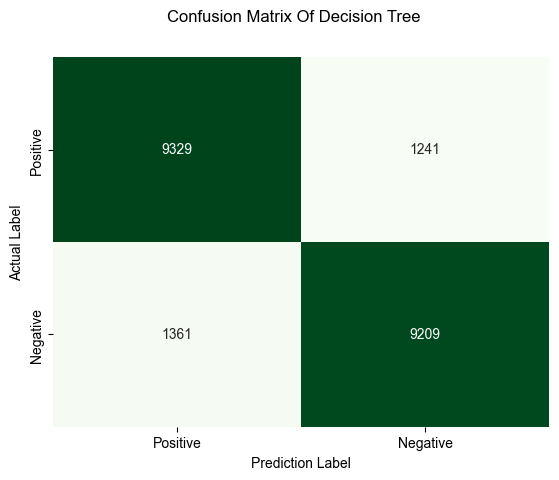

In [65]:
ConfusionMatrixDT = confusion_matrix_(y_test = y_test, y_pred=y_predDT)
confusion_matrix_display(confusion_matrix = ConfusionMatrixDT, name = 'Decision Tree')
False_PositiveDT, True_PositiveDT, False_NegativeDT, True_NegativeDT = generate_poitive_negative(confusion_matrix=ConfusionMatrixDT)

In [66]:
AccuracyDT = accuracy_score(True_Positive = True_PositiveDT, True_Negative = True_NegativeDT, False_Positive =False_PositiveDT, False_Negative = False_NegativeDT)
PrecisionDT= precision_score(True_Positive = True_PositiveDT, False_Positive =False_PositiveDT)

SensitivityDT = sensitivity_score(True_Positive = True_PositiveDT,  False_Negative = False_NegativeDT)
SpecificityDT = specificity_score(True_Negative = True_NegativeDT, False_Positive = False_PositiveDT)

F1ScoreDT = f1_score(True_Positive = True_PositiveDT, False_Negative = False_NegativeDT, False_Positive = False_PositiveDT)
ErrorDT = error_rate(True_Positive = True_PositiveDT, True_Negative = True_NegativeDT, False_Positive =False_PositiveDT, False_Negative = False_NegativeDT)

In [67]:
performance_metrics_data_frame(Accuracy = AccuracyDT, Precision = PrecisionDT, Sensitivity = SensitivityDT, Specificity = SpecificityDT, F1Score = F1ScoreDT, Error = ErrorDT)

Values
Accuracy     0.876916
Precision    0.882592
Sensitivity  0.872685
Specificity  0.881244
F1Score      0.877611
Error        0.123084

**4-K Nearest Neighbors**

In [68]:
Algorithm =KNeighborsClassifier(metric='cosine', n_neighbors=5)
model_4 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_4, X_train=X_train_vec, y_train=y_train)

KNeighborsClassifier(metric='cosine')

In [69]:
y_predKNN = model_4.predict(X_test_vec)

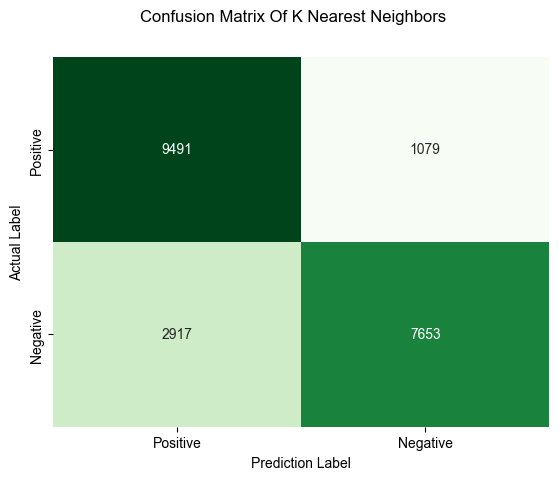

In [70]:
ConfusionMatrixKNN = confusion_matrix_(y_pred= y_predKNN, y_test=y_test)
confusion_matrix_display(confusion_matrix = ConfusionMatrixKNN, name = 'K Nearest Neighbors')
False_PositiveKNN, True_PositiveKNN, False_NegativeKNN, True_NegativeKNN = generate_poitive_negative(confusion_matrix=ConfusionMatrixKNN)

In [71]:
AccuracyKNN = accuracy_score(True_Positive = True_PositiveKNN, True_Negative = True_NegativeKNN, False_Positive =False_PositiveKNN, False_Negative = False_NegativeKNN)
PrecisionKNN= precision_score(True_Positive = True_PositiveKNN, False_Positive =False_PositiveKNN)

SensitivityKNN = sensitivity_score(True_Positive = True_PositiveKNN,  False_Negative = False_NegativeKNN)
SpecificityKNN = specificity_score(True_Negative = True_NegativeKNN, False_Positive = False_PositiveKNN)

F1ScoreKNN = f1_score(True_Positive = True_PositiveKNN, False_Negative = False_NegativeKNN, False_Positive = False_PositiveKNN)
ErrorKNN = error_rate(True_Positive = True_PositiveKNN, True_Negative = True_NegativeKNN, False_Positive =False_PositiveKNN, False_Negative = False_NegativeKNN)

In [72]:
performance_metrics_data_frame(Accuracy = AccuracyKNN, Precision = PrecisionKNN, Sensitivity = SensitivityKNN, Specificity = SpecificityKNN, F1Score = F1ScoreKNN, Error = ErrorKNN)

Values
Accuracy     0.810974
Precision    0.897919
Sensitivity  0.764910
Specificity  0.876432
F1Score      0.826095
Error        0.189026

**5-Random Forest**

In [73]:
Algorithm = RandomForestClassifier(criterion = 'entropy', n_estimators=300, random_state=22)
model_5 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_5, X_train=X_train_vec, y_train=y_train)

RandomForestClassifier(criterion='entropy', n_estimators=300, random_state=22)

In [74]:
y_predRF = model_5.predict(X_test_vec)

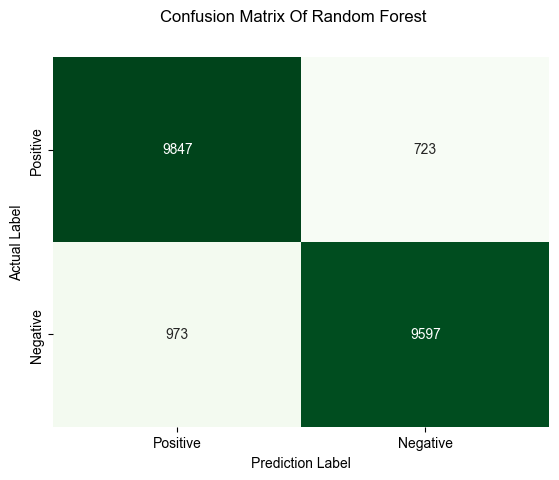

In [75]:
ConfusionMatrixRF = confusion_matrix_(y_test=y_test, y_pred=y_predRF)
confusion_matrix_display(confusion_matrix = ConfusionMatrixRF, name = 'Random Forest')
False_PositiveRF, True_PositiveRF, False_NegativeRF, True_NegativeRF = generate_poitive_negative(confusion_matrix=ConfusionMatrixRF)

In [76]:
AccuracyRF = accuracy_score(True_Positive = True_PositiveRF, True_Negative = True_NegativeRF, False_Positive =False_PositiveRF, False_Negative = False_NegativeRF)
PrecisionRF= precision_score(True_Positive = True_PositiveRF, False_Positive =False_PositiveRF)

SensitivityRF = sensitivity_score(True_Positive = True_PositiveRF,  False_Negative = False_NegativeRF)
SpecificityRF = specificity_score(True_Negative = True_NegativeRF, False_Positive = False_PositiveRF)

F1ScoreRF = f1_score(True_Positive = True_PositiveRF, False_Negative = False_NegativeRF, False_Positive = False_PositiveRF)
ErrorRF = error_rate(True_Positive = True_PositiveRF, True_Negative = True_NegativeRF, False_Positive =False_PositiveRF, False_Negative = False_NegativeRF)

In [77]:
performance_metrics_data_frame(Accuracy = AccuracyRF, Precision = PrecisionRF, Sensitivity = SensitivityRF, Specificity = SpecificityRF, F1Score = F1ScoreRF, Error = ErrorRF)

Values
Accuracy     0.919773
Precision    0.931599
Sensitivity  0.910074
Specificity  0.929942
F1Score      0.920711
Error        0.080227

**6-SGD Classifier**

In [78]:
Algorithm = SGDClassifier(loss='hinge')
model_6 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_6, X_train=X_train_vec, y_train=y_train)

SGDClassifier()

In [79]:
y_predSGD = model_6.predict(X_test_vec)

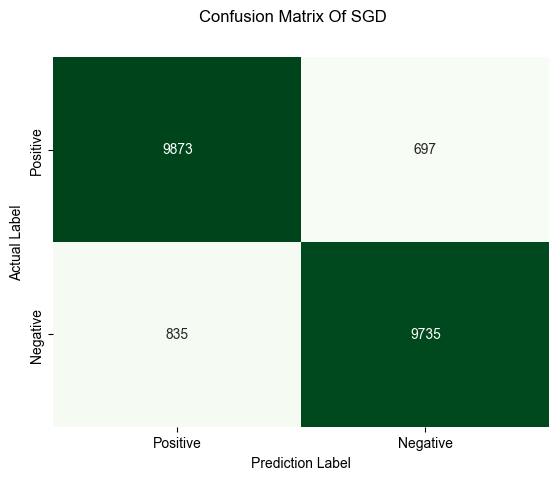

In [80]:
ConfusionMatrixSGD = confusion_matrix_(y_test=y_test, y_pred=y_predSGD)
confusion_matrix_display(confusion_matrix = ConfusionMatrixSGD, name = 'SGD')
False_PositiveSGD, True_PositiveSGD, False_NegativeSGD, True_NegativeSGD = generate_poitive_negative(confusion_matrix=ConfusionMatrixSGD)

In [81]:
AccuracySGD = accuracy_score(True_Positive = True_PositiveSGD, True_Negative = True_NegativeSGD, False_Positive =False_PositiveSGD, False_Negative = False_NegativeSGD)
PrecisionSGD= precision_score(True_Positive = True_PositiveSGD, False_Positive =False_PositiveSGD)

SensitivitySGD = sensitivity_score(True_Positive = True_PositiveSGD,  False_Negative = False_NegativeSGD)
SpecificitySGD = specificity_score(True_Negative = True_NegativeSGD, False_Positive = False_PositiveSGD)

F1ScoreSGD = f1_score(True_Positive = True_PositiveSGD, False_Negative = False_NegativeSGD, False_Positive = False_PositiveSGD)
ErrorSGD = error_rate(True_Positive = True_PositiveSGD, True_Negative = True_NegativeSGD, False_Positive =False_PositiveSGD, False_Negative = False_NegativeSGD)

In [82]:
performance_metrics_data_frame(Accuracy = AccuracySGD, Precision = PrecisionSGD, Sensitivity = SensitivitySGD, Specificity = SpecificitySGD, F1Score = F1ScoreSGD, Error = ErrorSGD)

Values
Accuracy     0.927531
Precision    0.934059
Sensitivity  0.922021
Specificity  0.933186
F1Score      0.928001
Error        0.072469

**7-XGBOOST Classifier**

In [83]:
Algorithm = XGBClassifier();
model_7 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_7, X_train=X_train_vec, y_train=y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [84]:
y_predXGB = model_7.predict(X_test_vec)

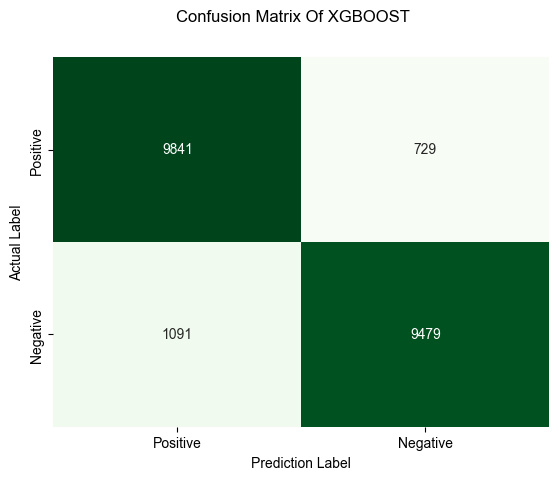

In [85]:
ConfusionMatrixXGB= confusion_matrix_(y_test=y_test, y_pred=y_predXGB)
confusion_matrix_display(confusion_matrix = ConfusionMatrixXGB, name = 'XGBOOST')
False_PositiveXGB, True_PositiveXGB, False_NegativeXGB, True_NegativeXGB = generate_poitive_negative(confusion_matrix=ConfusionMatrixXGB)

In [86]:
AccuracyXGB = accuracy_score(True_Positive = True_PositiveXGB, True_Negative = True_NegativeXGB, False_Positive =False_PositiveXGB, False_Negative = False_NegativeXGB)
PrecisionXGB= precision_score(True_Positive = True_PositiveXGB, False_Positive =False_PositiveXGB)

SensitivityXGB = sensitivity_score(True_Positive = True_PositiveXGB,  False_Negative = False_NegativeXGB)
SpecificityXGB = specificity_score(True_Negative = True_NegativeXGB, False_Positive = False_PositiveXGB)

F1ScoreXGB = f1_score(True_Positive = True_PositiveXGB, False_Negative = False_NegativeXGB, False_Positive = False_PositiveXGB)
ErrorXGB = error_rate(True_Positive = True_PositiveXGB, True_Negative = True_NegativeXGB, False_Positive =False_PositiveXGB, False_Negative = False_NegativeXGB)

In [87]:
performance_metrics_data_frame(Accuracy = AccuracyXGB, Precision = PrecisionXGB, Sensitivity = SensitivityXGB, Specificity = SpecificityXGB, F1Score = F1ScoreXGB, Error = ErrorXGB)

Values
Accuracy     0.913907
Precision    0.931031
Sensitivity  0.900201
Specificity  0.928585
F1Score      0.915357
Error        0.086093

# Deep Learning

**1.Preprocessing**

In [88]:
tokenizer, vocab_size, max_length, encoded_X_train , encoded_X_test, word_index= deeplearning_preprcosesing_(X_train=X_train, X_test=X_test,  truncating='pre', padding='pre')

In [89]:
print('The Vocab Size Is :',vocab_size)
print('')
print('The Max Length Is :', max_length)

The Vocab Size Is : 115376

The Max Length Is : 387


**2.Word Index**

In [90]:
Word_Index = word_index
Word_Index_ =pd.DataFrame(((list(Word_Index.items()))), columns=['Word', 'Index'])
Word_Index_.head()

Word  Index
0      <oov>      1
1     الفندق      2
2  الاستقبال      3
3     الغرفه      4
4         شي      5

**3.Train Word2Vector**

In [91]:
word_2_vec_(data = Data[0], vector_size = 50, sg = 1, name = "Arabic Word Vector")

**4.Generate Word Vector**

In [92]:
word_vector = word_vector_(model_path = 'Arabic Word Vector.txt', vocab_size = vocab_size , tokenizer = tokenizer)

# Deep Learing Models

**8-LSTM**

Epoch 1/10
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 197s 74ms/step - accuracy: 0.7576 - loss: 0.4696 - val_accuracy: 0.9231 - val_loss: 0.2104 - learning_rate: 1.0000e-04
Epoch 2/10
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 195s 74ms/step - accuracy: 0.9429 - loss: 0.1721 - val_accuracy: 0.9342 - val_loss: 0.1872 - learning_rate: 1.0000e-04
Epoch 3/10
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 187s 71ms/step - accuracy: 0.9576 - loss: 0.1320 - val_accuracy: 0.9337 - val_loss: 0.1865 - learning_rate: 1.0000e-04
Epoch 4/10
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 198s 75ms/step - accuracy: 0.9676 - loss: 0.1065 - val_accuracy: 0.9309 - val_loss: 0.1972 - learning_rate: 1.0000e-04
Epoch 5/10
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 198s 75ms/step - accuracy: 0.9745 - loss: 0.0867 - val_accuracy: 0.9297 - val_loss: 0.2150 - learning_rate: 1.0000e-04
Epoch 6/10
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 188s 71ms/step - accuracy: 0.9798 - loss: 0.0708 - val_accuracy: 0.9263 - val_loss: 0.2309 - learning_rate: 1.0000e-04
Epoch 7/10
2643/2643 ━━━━━━━━━━━━━

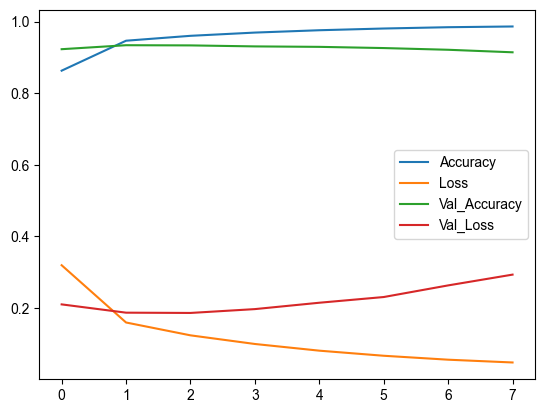

In [93]:
model_8 =lstm_(vocab_size = vocab_size +1 , embedding_dim = 50, max_length = max_length, units = 32, embeddings_matrix = word_vector)
model_compile(model=model_8)
history = model_fit(model=model_8, X_train=encoded_X_train, y_train=y_train, epochs=10, X_test=encoded_X_test, y_test=y_test, batch_size=32)
plot_changes(histoty=history)  

**9-GRU**

Epoch 1/10
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 220s 83ms/step - accuracy: 0.7582 - loss: 0.4793 - val_accuracy: 0.9277 - val_loss: 0.1976 - learning_rate: 1.0000e-04
Epoch 2/10
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 225s 85ms/step - accuracy: 0.9470 - loss: 0.1569 - val_accuracy: 0.9390 - val_loss: 0.1728 - learning_rate: 1.0000e-04
Epoch 3/10
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 216s 82ms/step - accuracy: 0.9618 - loss: 0.1173 - val_accuracy: 0.9394 - val_loss: 0.1756 - learning_rate: 1.0000e-04
Epoch 4/10
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 217s 82ms/step - accuracy: 0.9711 - loss: 0.0918 - val_accuracy: 0.9368 - val_loss: 0.1846 - learning_rate: 1.0000e-04
Epoch 5/10
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 222s 84ms/step - accuracy: 0.9781 - loss: 0.0726 - val_accuracy: 0.9345 - val_loss: 0.2054 - learning_rate: 1.0000e-04
Epoch 6/10
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 218s 82ms/step - accuracy: 0.9829 - loss: 0.0581 - val_accuracy: 0.9289 - val_loss: 0.2286 - learning_rate: 1.0000e-04
Epoch 7/10
2643/2643 ━━━━━━━━━━━━━

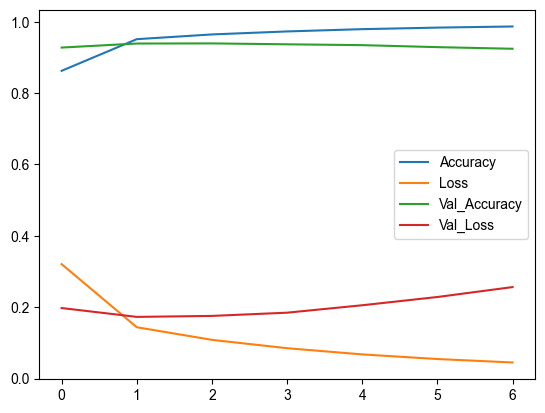

In [94]:
model_9 = gru_(vocab_size = vocab_size + 1, embedding_dim = 50, max_length = max_length, units = 32,  embeddings_matrix = word_vector)
model_compile(model=model_9)
history = model_fit(model=model_9, X_train=encoded_X_train, y_train=y_train, epochs=10, X_test=encoded_X_test, y_test=y_test, batch_size=32)
plot_changes(histoty=history)

**10-Bidirectional LSTM**

Epoch 1/10
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 303s 114ms/step - accuracy: 0.7662 - loss: 0.4602 - val_accuracy: 0.9269 - val_loss: 0.2190 - learning_rate: 1.0000e-04
Epoch 2/10
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 307s 116ms/step - accuracy: 0.9421 - loss: 0.1807 - val_accuracy: 0.9325 - val_loss: 0.1990 - learning_rate: 1.0000e-04
Epoch 3/10
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 292s 111ms/step - accuracy: 0.9568 - loss: 0.1413 - val_accuracy: 0.9347 - val_loss: 0.1994 - learning_rate: 1.0000e-04
Epoch 4/10
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 302s 114ms/step - accuracy: 0.9661 - loss: 0.1155 - val_accuracy: 0.9307 - val_loss: 0.2071 - learning_rate: 1.0000e-04
Epoch 5/10
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 302s 114ms/step - accuracy: 0.9724 - loss: 0.0963 - val_accuracy: 0.9297 - val_loss: 0.2186 - learning_rate: 1.0000e-04
Epoch 6/10
2643/2643 ━━━━━━━━━━━━━━━━━━━━ 303s 115ms/step - accuracy: 0.9778 - loss: 0.0795 - val_accuracy: 0.9269 - val_loss: 0.2353 - learning_rate: 1.0000e-04
Epoch 7/10
2643/2643 ━━━━━━━

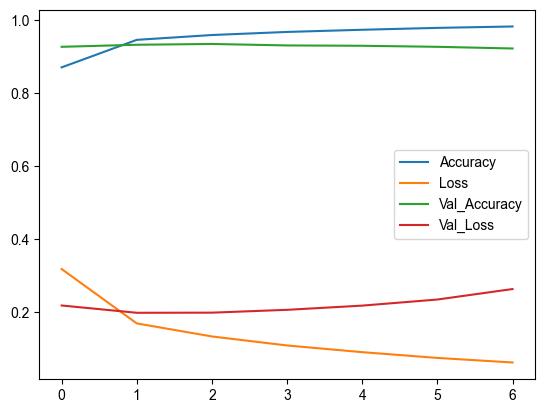

In [95]:
model_10 = bidirectional_lstm(vocab_size = vocab_size + 1, embedding_dim = 50, max_length = max_length, units = 32, embeddings_matrix = word_vector)
model_compile(model=model_10)
history = model_fit(model=model_10, X_train=encoded_X_train, y_train=y_train, epochs=10, X_test=encoded_X_test, y_test=y_test, batch_size=32)
plot_changes(histoty=history)

# Model Inference

**1-Naive Bayes**

In [96]:
machine_learning_inference(model=model_1,vectorizer=Vectorizer, text = reviews)

Review: لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.
Sentiment: Negative

Review: الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.
Sentiment: Positive

Review: كانت الأسرة في الغرفة مريحة جدًا.
Sentiment: Positive

Review: الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.
Sentiment: Negative

Review: كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.
Sentiment: Positive

Review: الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.
Sentiment: Positive

Review: الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.
Sentiment: Positive

Review: الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.
Sentiment: Positive

Review: استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.
Sentiment: Positive

Review: المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إ

**2-Logistic Regression**

In [97]:
machine_learning_inference(model=model_2,vectorizer=Vectorizer, text = reviews)

Review: لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.
Sentiment: Negative

Review: الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.
Sentiment: Positive

Review: كانت الأسرة في الغرفة مريحة جدًا.
Sentiment: Positive

Review: الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.
Sentiment: Negative

Review: كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.
Sentiment: Positive

Review: الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.
Sentiment: Positive

Review: الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.
Sentiment: Positive

Review: الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.
Sentiment: Positive

Review: استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.
Sentiment: Positive

Review: المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إ

**3-Decision Tree**

In [98]:
machine_learning_inference(model=model_3,vectorizer=Vectorizer, text = reviews)

Review: لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.
Sentiment: Negative

Review: الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.
Sentiment: Positive

Review: كانت الأسرة في الغرفة مريحة جدًا.
Sentiment: Negative

Review: الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.
Sentiment: Negative

Review: كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.
Sentiment: Negative

Review: الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.
Sentiment: Positive

Review: الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.
Sentiment: Positive

Review: الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.
Sentiment: Positive

Review: استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.
Sentiment: Positive

Review: المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إ

**4-K Nearest Neighbors**

In [99]:
machine_learning_inference(model=model_4,vectorizer=Vectorizer, text = reviews)

Review: لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.
Sentiment: Positive

Review: الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.
Sentiment: Negative

Review: كانت الأسرة في الغرفة مريحة جدًا.
Sentiment: Positive

Review: الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.
Sentiment: Negative

Review: كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.
Sentiment: Positive

Review: الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.
Sentiment: Negative

Review: الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.
Sentiment: Positive

Review: الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.
Sentiment: Positive

Review: استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.
Sentiment: Positive

Review: المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إ

**5-Random Forest**

In [100]:
machine_learning_inference(model=model_5,vectorizer=Vectorizer, text = reviews)

Review: لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.
Sentiment: Negative

Review: الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.
Sentiment: Positive

Review: كانت الأسرة في الغرفة مريحة جدًا.
Sentiment: Positive

Review: الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.
Sentiment: Negative

Review: كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.
Sentiment: Positive

Review: الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.
Sentiment: Positive

Review: الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.
Sentiment: Positive

Review: الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.
Sentiment: Positive

Review: استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.
Sentiment: Positive

Review: المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إ

**6-SGD Classifier**

In [101]:
machine_learning_inference(model=model_6,vectorizer=Vectorizer, text = reviews)

Review: لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.
Sentiment: Negative

Review: الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.
Sentiment: Positive

Review: كانت الأسرة في الغرفة مريحة جدًا.
Sentiment: Positive

Review: الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.
Sentiment: Negative

Review: كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.
Sentiment: Positive

Review: الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.
Sentiment: Positive

Review: الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.
Sentiment: Positive

Review: الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.
Sentiment: Positive

Review: استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.
Sentiment: Positive

Review: المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إ

**7-XGBOOST**

In [102]:
machine_learning_inference(model = model_7, vectorizer=Vectorizer, text = reviews)

Review: لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.
Sentiment: Negative

Review: الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.
Sentiment: Positive

Review: كانت الأسرة في الغرفة مريحة جدًا.
Sentiment: Positive

Review: الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.
Sentiment: Negative

Review: كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.
Sentiment: Positive

Review: الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.
Sentiment: Positive

Review: الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.
Sentiment: Positive

Review: الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.
Sentiment: Positive

Review: استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.
Sentiment: Positive

Review: المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إ

**8-LSTM**

In [103]:
deep_learning_inference(model = model_8, text = reviews , tokenizer = tokenizer, max_length = max_length)

Review: لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.
Sentiment: Negative

Review: الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.
Sentiment: Negative

Review: كانت الأسرة في الغرفة مريحة جدًا.
Sentiment: Negative

Review: الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.
Sentiment: Negative

Review: كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.
Sentiment: Negative

Review: الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.
Sentiment: Negative

Review: الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.
Sentiment: Positive

Review: الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.
Sentiment: Positive

Review: استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.
Sentiment: Positive

Review: المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إ

**9-Bidirectional LSTM**

In [104]:
deep_learning_inference(model = model_9, text = reviews , tokenizer = tokenizer, max_length = max_length)

Review: لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.
Sentiment: Negative

Review: الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.
Sentiment: Negative

Review: كانت الأسرة في الغرفة مريحة جدًا.
Sentiment: Negative

Review: الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.
Sentiment: Negative

Review: كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.
Sentiment: Negative

Review: الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.
Sentiment: Positive

Review: الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.
Sentiment: Positive

Review: الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.
Sentiment: Positive

Review: استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.
Sentiment: Positive

Review: المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إ

**10-GRU**

In [105]:
deep_learning_inference(model = model_10, text = reviews , tokenizer = tokenizer, max_length = max_length)

Review: لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.
Sentiment: Negative

Review: الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.
Sentiment: Positive

Review: كانت الأسرة في الغرفة مريحة جدًا.
Sentiment: Positive

Review: الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.
Sentiment: Negative

Review: كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.
Sentiment: Positive

Review: الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.
Sentiment: Positive

Review: الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.
Sentiment: Positive

Review: الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.
Sentiment: Positive

Review: استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.
Sentiment: Positive

Review: المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إ

# Transformers

In [108]:
sentiment_analysis_transformers(reviews)

Review: لقد كانت تجربتي في هذا الفندق سيئة للغاية. الغرفة كانت غير نظيفة والموظفون لم يكونوا متعاونين على الإطلاق.
Sentiment: Negative

Review: الخدمة في الفندق كانت مخيبة للآمال. انتظرت أكثر من ساعة لتلقي الطعام في المطعم.
Sentiment: Negative

Review: كانت الأسرة في الغرفة مريحة جدًا.
Sentiment: Positive

Review: الفندق لا يستحق الأسعار المرتفعة التي يفرضها. الغرف ليست مريحة كما توقعت.
Sentiment: Negative

Review: كانت إقامتي في هذا الفندق رائعة. الغرفة كانت نظيفة ومريحة، والموظفون كانوا ودودين جدًا.
Sentiment: Positive

Review: الخدمة في الفندق كانت ممتازة. الموظفون كانوا دائمًا مستعدين لمساعدتي في أي شيء احتاجه.
Sentiment: Positive

Review: الفندق يقع في موقع مثالي بالقرب من الشاطئ والأسواق. كانت كل شيء على مرمى البصر.
Sentiment: Positive

Review: الفندق لديه جو مريح، وهو مكان مثالي للاسترخاء بعد يوم طويل من السفر.
Sentiment: Positive

Review: استمتعت بتناول الطعام في المطعم. الأطباق كانت لذيذة ومتنوعة.
Sentiment: Positive

Review: المرافق في الفندق قديمة وغير نظيفة. أرى أنه يحتاج إ